# Entendimento de Negócio

## Contexto

São Petersburgo é a segunda maior cidade russa, o dataset Real Estate Saint Petersburg 2014 - 2019 contém uma rica quantidade de informações sobre o mercado imobiliário local. Os dados incluem variáveis que descrevem tanto os imóveis, quanto a região onde cada um está localizado. 

## Metas e objetivos

Portanto meu objetivo neste projeto é explorar os dados para construir um modelo de machine learning capaz de predizer os preços dos imóveis na cidade. 

# Entendimento dos dados
## Features

|Coluna|Descrição|
|--|--|
|`airports_nearest`|Distância em metros para o aeroporto mais próximo|
|`balcony`| Número de sacadas|
|`ceiling_height`| Altura em metros do telhado|
|`cityCenters_nearest`| Distância até o centro da cidade em metros|
|`days_exposition`| Número de dias que o anúncio esteve ativo|
|`first_day_exposition`| Data de publicação do anúncio|
|`floor`| Total de andares do imóvel|
|`floors_total`| Total de andares no prédio onde o imóvel está localizado|
|`is_apartment`| Se é um apartamento (bool)|
|`kitchen_area`| Área da cozinha em metros quadrados|
|`last_price`| Último preço de anúncio|
|`living_area`| Área de convivência em metros quadrados|
|`locality_name`| Nome da localidade|
|`open_plan`| Se a propriedade tem um plano aberto (bool)|
|`parks_around3000`| Número de parques em um raio de 3km|
|`parks_nearest`| Distância do parque mais próximo em metros|
|`ponds_around3000`| Número de corpos de água em um raio de 3km|
|`ponds_nearest`| Distância do corpo de água mais próximo|
|`rooms`| Número de quartos|
|`studio`| Se é um apartamento do tipo studio (bool)|
|`total_area`| Área total do imóvel em metros quadrados|
|`total_images`| Número de imagens no anúncio|

## Importação de bibliotecas e carregamento dos dados

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import TargetEncoder

import warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fast')
blue_palette = ['#003f5c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
sns.set_palette(blue_palette)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/raw/real_estate_data.csv", sep = '\t')

## Qualidade dos dados

In [3]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 23699 linhas e 22 colunas.


In [4]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 3 colunas categóricas.
O dataset possui: 17 colunas numéricas.


In [5]:
print(f"O dataset possui {df.duplicated().sum()} dados duplicados.")

O dataset possui 0 dados duplicados.


In [6]:
print(f"O dataset possui {df.isnull().sum().sum()} dados nulos.")

O dataset possui 101441 dados nulos.


Vamos checar a proporção de dados nulos em cada coluna. 

In [7]:
df.isnull().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

Podemos usar imputação para as colunas com menos de 30% de dados nulos, penso que seja uma melhor solução não utilizar aquelas com uma proporção maior que essa.

In [8]:
colunas = df.isnull().mean()
filtro = colunas[colunas < 0.30].index
df = df[filtro]
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.0


Também é interessante remover variáveis ligadas ao site, e deixar só aquelas ligadas aos imóveis.

In [9]:
df = df.drop(columns = ["total_images", "first_day_exposition", "days_exposition"], axis = 1)
df.head()

,last_price,total_area,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000
0,13000000.0,108.0,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0
1,3350000.0,40.4,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0
2,5196000.0,56.0,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0
3,64900000.0,159.0,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0
4,10000000.0,100.0,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   last_price           23699 non-null  float64
 1   total_area           23699 non-null  float64
 2   rooms                23699 non-null  int64  
 3   floors_total         23613 non-null  float64
 4   living_area          21796 non-null  float64
 5   floor                23699 non-null  int64  
 6   studio               23699 non-null  bool   
 7   open_plan            23699 non-null  bool   
 8   kitchen_area         21421 non-null  float64
 9   locality_name        23650 non-null  object 
 10  airports_nearest     18157 non-null  float64
 11  cityCenters_nearest  18180 non-null  float64
 12  parks_around3000     18181 non-null  float64
 13  ponds_around3000     18181 non-null  float64
dtypes: bool(2), float64(9), int64(2), object(1)
memory usage: 2.2+ MB


## Análise Exploratória de Dados
### Estatísticas descritivas

In [11]:
df.select_dtypes(include = 'number').describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
last_price,23699.0,6541548.77,10887013.27,12190.0,3400000.0,4650000.0,6800000.0,763000000.0
total_area,23699.0,60.35,35.65,12.0,40.0,52.0,69.9,900.0
rooms,23699.0,2.07,1.08,0.0,1.0,2.0,3.0,19.0
floors_total,23613.0,10.67,6.60,1.0,5.0,9.0,16.0,60.0
living_area,21796.0,34.46,22.03,2.0,18.6,30.0,42.3,409.7
floor,23699.0,5.89,4.89,1.0,2.0,4.0,8.0,33.0
kitchen_area,21421.0,10.57,5.91,1.3,7.0,9.1,12.0,112.0
airports_nearest,18157.0,28793.67,12630.88,0.0,18585.0,26726.0,37273.0,84869.0
cityCenters_nearest,18180.0,14191.28,8608.39,181.0,9238.0,13098.5,16293.0,65968.0
parks_around3000,18181.0,0.61,0.80,0.0,0.0,0.0,1.0,3.0


In [12]:
df.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq
studio,23699,2,False,23550
open_plan,23699,2,False,23632
locality_name,23650,364,Санкт-Петербург,15721


### Correlações

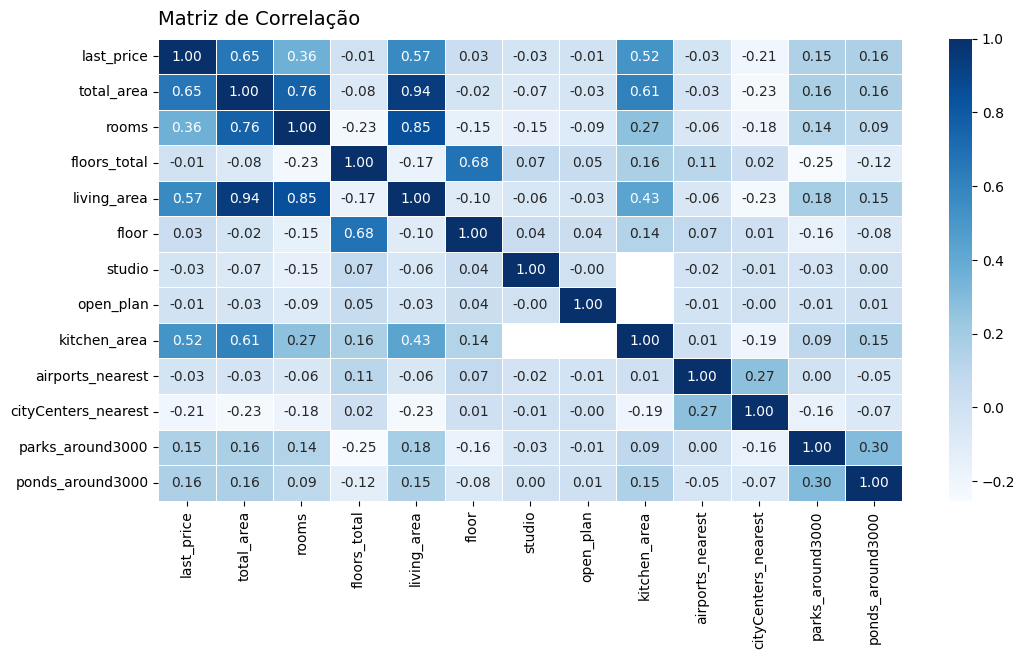

In [13]:
corr = df.corr(numeric_only = True)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, annot = True, fmt = ".2f", linewidths=0.5, cmap = "Blues")
ax.set_title("Matriz de Correlação", fontsize = 14, pad = 10, loc = "left")
plt.show()

- Dos fatores relacionados a estrutura do imóvel, a área total, tamanho da cozinha e o espaço de convivência são os que mostram correlação mais forte com o preço. A área total no mercado imobiliário sempre uma variável chave na precificação de um imóvel já que o ponto base da avaliação imobiliária é o preço do metro quadrado na região.
- Dentre os outros fatores, estar longe do centro desvaloriza o imóvel, e ter parques e fontes de água próximas valorizam.

### Comportamento do target

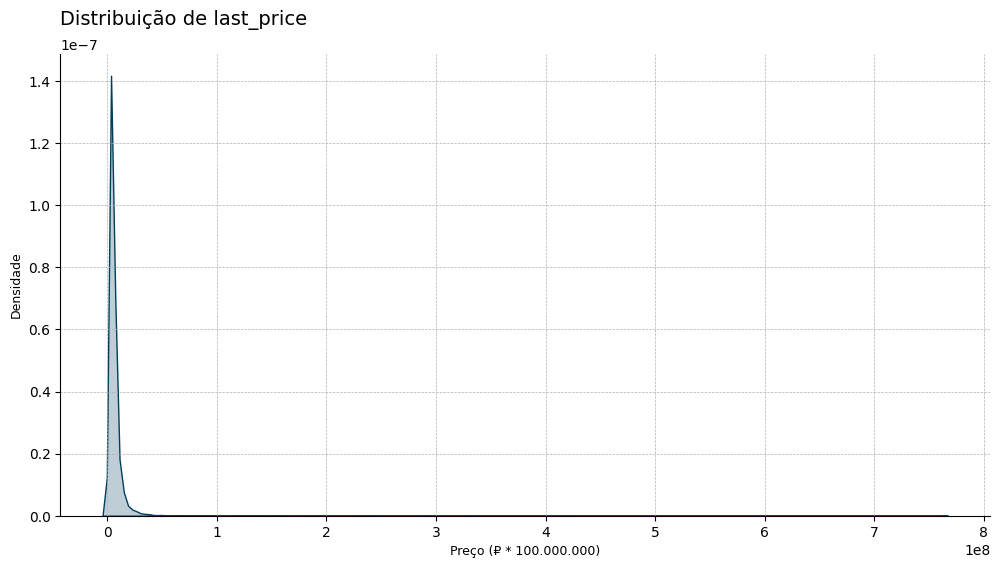

In [15]:
fig , ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(df["last_price"], fill = True)
ax.set_title("Distribuição de last_price", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Preço (₽ * 100.000.000)", fontsize = 9)
ax.set_ylabel("Densidade", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

O target apresenta uma assimetria à direita, uma boa solução é uma transformação em $\log$. 

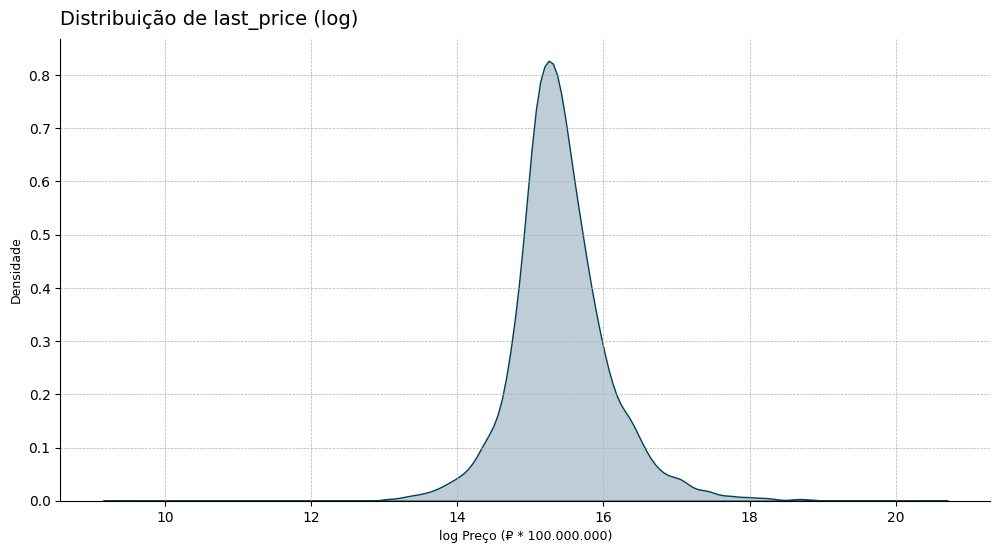

In [16]:
fig , ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(np.log1p(df["last_price"]), fill = True)
ax.set_title("Distribuição de last_price (log)", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("log Preço (₽ * 100.000.000)", fontsize = 9)
ax.set_ylabel("Densidade", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


Com a transformação em $\log$ conseguimos uma distribuição próxima à normal. 

# Preparação dos dados

In [14]:
df["studio"] = df["studio"].map({"True": 1, "False": 0})
df["open_plan"] = df["open_plan"].map({"True": 1, "False": 0})

In [15]:
df["log_price"] = np.log1p(df["last_price"])

## Pré-processamento

In [16]:
features = df.drop(columns = ["last_price", "log_price"]).columns.to_list()
target = "log_price"

X = df[features]
y = df[target]

In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 42)

In [19]:
cat_features = ["studio", "open_plan", "locality_name"]
num_features = X.drop(columns = ["studio", "open_plan", "locality_name"], axis = 1).columns.to_list()

In [20]:
num_features

['total_area',
 'rooms',
 'floors_total',
 'living_area',
 'floor',
 'kitchen_area',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'ponds_around3000']

In [22]:
cat_transformer = Pipeline([
    ('cat_imput', CategoricalImputer(imputation_method = 'frequent')),
    ('cat_encoding', TargetEncoder())
])

num_transformer = Pipeline([
    ('num_imput', MeanMedianImputer(imputation_method = 'median'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# Modelagem
## Modelo base

In [23]:
reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective = 'reg:squarederror', random_state = 42))
])

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('cat_encoding',
                                                                   TargetEncoder())]),
                                                  ['studio', 'open_plan',
                                                   'locality_name']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imput',
                                                                   MeanMedianImputer())]),
                                                  ['total_area', 'rooms',
                                                   'floors_total',
                                                   'living_area', 'floor',
                                                   'kitche...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [24]:
y_pred = reg.predict(X_val)

In [25]:
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared = False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Métricas - Validação\n{'-' * 30}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Métricas - Validação
------------------------------
MSE: 0.0674
RMSE: 0.2596
MAE: 0.1569
R2 Score: 0.8483


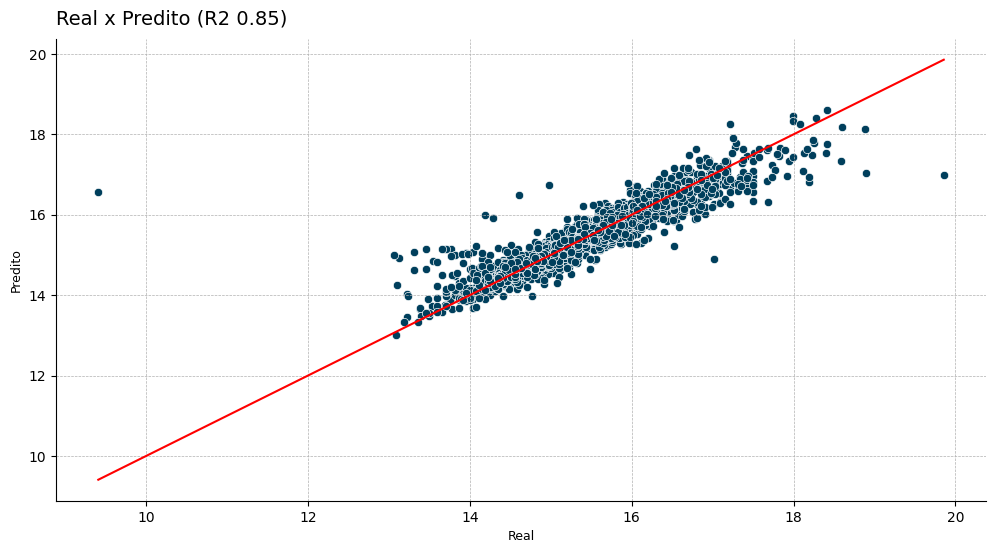

In [26]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_val, y = y_pred)
sns.lineplot(x = [min(y_val), max(y_val)], y = [min(y_val), max(y_val)], color = 'red')
ax.set_title(f"Real x Predito (R2 {r2:.2f})", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Real", fontsize = 9)
ax.set_ylabel("Predito", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Por conta da transformação em $\log$, temos que pensar a interpetação das métricas de forma diferente:

- O R2 Score significa que o modelo explica cerca de 84,83% da variabilidade nos preços dos imóveis;
- O RMSE de 0.2596 significa que as previsões podem variar em torno de 25,96% para mais ou para menos do valor real;
- O MAE de 0.1569 indica que em média, as previsões têm um erro absoluto de cerca de 15,69% do valor real do imóvel.

Com este modelo base vamos buscar uma otimização para seus hiper-parâmetros. Em minha experiência como corretor de imóveis sempre usei a margem de negociação de 20% para mais ou menos então vamos tentar reduzir um pouco o Root Mean Squared Error para chegar a esta margem, além de potencialmente melhorar as outras métricas do modelo como o Mean Absolute Error.

## Modelo otimizado

In [27]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = Pipeline([('preprocessor', preprocessor), ('model', XGBRegressor(**params))])
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared = False)
    return rmse

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-11-27 21:43:56,838] A new study created in memory with name: no-name-5edda792-f442-4f66-9eee-65ec548eece0
[I 2024-11-27 21:44:05,273] Trial 0 finished with value: 0.27415330826558326 and parameters: {'learning_rate': 0.007389058947042985, 'max_depth': 8, 'subsample': 0.0561906863595801, 'colsample_bytree': 0.9710479277919656, 'min_child_weight': 15}. Best is trial 0 with value: 0.27415330826558326.
[I 2024-11-27 21:44:15,174] Trial 1 finished with value: 0.2649544055667087 and parameters: {'learning_rate': 0.004650319446408613, 'max_depth': 6, 'subsample': 0.8553406597008262, 'colsample_bytree': 0.5027768551654601, 'min_child_weight': 11}. Best is trial 1 with value: 0.2649544055667087.
[I 2024-11-27 21:44:18,647] Trial 2 finished with value: 0.2647445801544611 and parameters: {'learning_rate': 0.06792149324362526, 'max_depth': 2, 'subsample': 0.6100833040259764, 'colsample_bytree': 0.5299811195001063, 'min_child_weight': 13}. Best is trial 2 with value: 0.2647445801544611.
[I 

In [29]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor RMSE: {study.best_value}")

Melhores hiperparâmetros: {'learning_rate': 0.04939478561082139, 'max_depth': 7, 'subsample': 0.7882157209337015, 'colsample_bytree': 0.6095977710612492, 'min_child_weight': 18}
Melhor RMSE: 0.24862594085965065


In [30]:
params = {'objective': 'reg:squarederror', 
          'n_estimators': 1000,
          'verbosity': 0,
          'learning_rate': 0.04939478561082139, 
          'max_depth': 7, 
          'subsample': 0.7882157209337015, 
          'colsample_bytree': 0.6095977710612492, 
          'min_child_weight': 18}

In [32]:
reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**params, random_state = 42))
])

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('cat_encoding',
                                                                   TargetEncoder())]),
                                                  ['studio', 'open_plan',
                                                   'locality_name']),
                                                 ('num',
                                                  Pipeline(steps=[('num_imput',
                                                                   MeanMedianImputer())]),
                                                  ['total_area', 'rooms',
                                                   'floors_total',
                                                   'living_area', 'floor',
                                                   'kitche...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04939478561082139, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=18, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [33]:
y_pred = reg.predict(X_val)

In [34]:
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared = False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Métricas - Validação (Pós Otimização)\n{'-' * 40}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Métricas - Validação (Pós Otimização)
----------------------------------------
MSE: 0.0628
RMSE: 0.2507
MAE: 0.1519
R2 Score: 0.8586


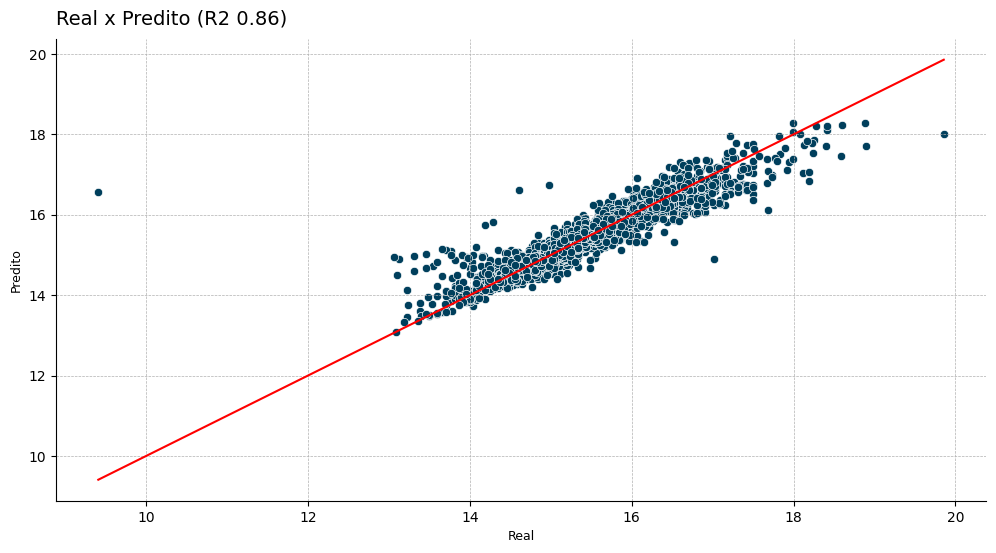

In [35]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_val, y = y_pred)
sns.lineplot(x = [min(y_val), max(y_val)], y = [min(y_val), max(y_val)], color = 'red')
ax.set_title(f"Real x Predito (R2 {r2:.2f})", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Real", fontsize = 9)
ax.set_ylabel("Predito", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Avaliação

In [36]:
y_pred = reg.predict(X_test)

In [37]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared = False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Métricas - Teste\n{'-' * 40}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Métricas - Teste
----------------------------------------
MSE: 0.0452
RMSE: 0.2126
MAE: 0.1423
R2 Score: 0.8897


In [38]:
scoring = make_scorer(mean_squared_error)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

scores = cross_val_score(reg, X_train, y_train, cv = cv, scoring = scoring)
print(f"Média do RMSE: {np.sqrt(scores).mean()}")
print(f"Desvio Padrão do RMSE: {np.sqrt(scores).std()}")

Média do RMSE: 0.21907832403014807
Desvio Padrão do RMSE: 0.008435433005996303


A partir da consistência entre os resultados do RMSE e baixo desvio padrão, é possível observar que o modelo mostra uma boa capacidade de generalização (até com uma sútil melhora nos dados de teste). Em média na validação cruzada o RMSE é de 21,90% que é próximo do objetivo inicial, o Error Médio Absoluta também mostra uma boa performance com 14,23% que também performa bem dentro da margem de avaliação que sempre usei durante minha carreira no setor imobiliário. Mais uma vez, vamos observar a visualização do Real x Predito. 

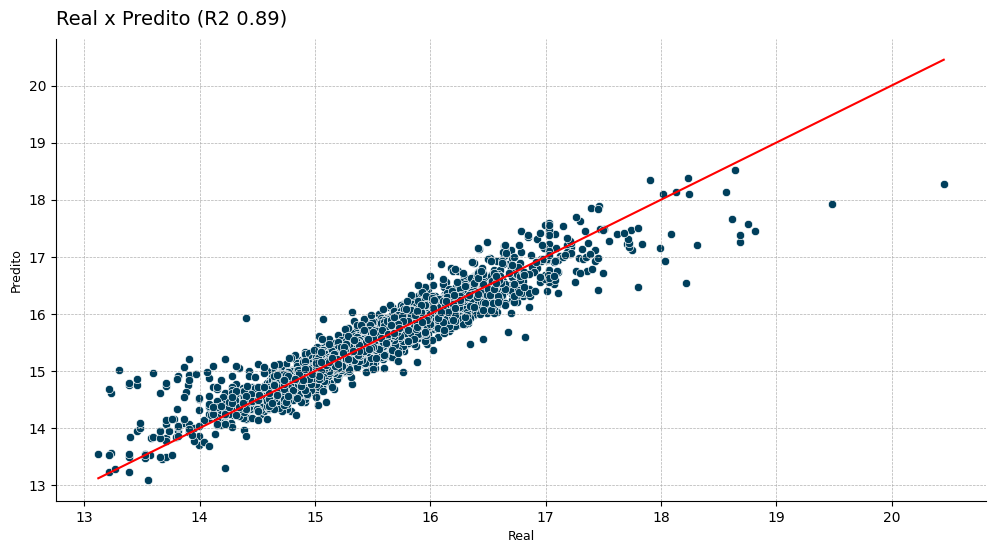

In [39]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred)
sns.lineplot(x = [min(y_test), max(y_test)], y = [min(y_test), max(y_test)], color = 'red')
ax.set_title(f"Real x Predito (R2 {r2:.2f})", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Real", fontsize = 9)
ax.set_ylabel("Predito", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Vamos observar também a distribuição dos resíduos, sua normalidade (ou não normalidade) é mais uma forma de validar nossos resultados.

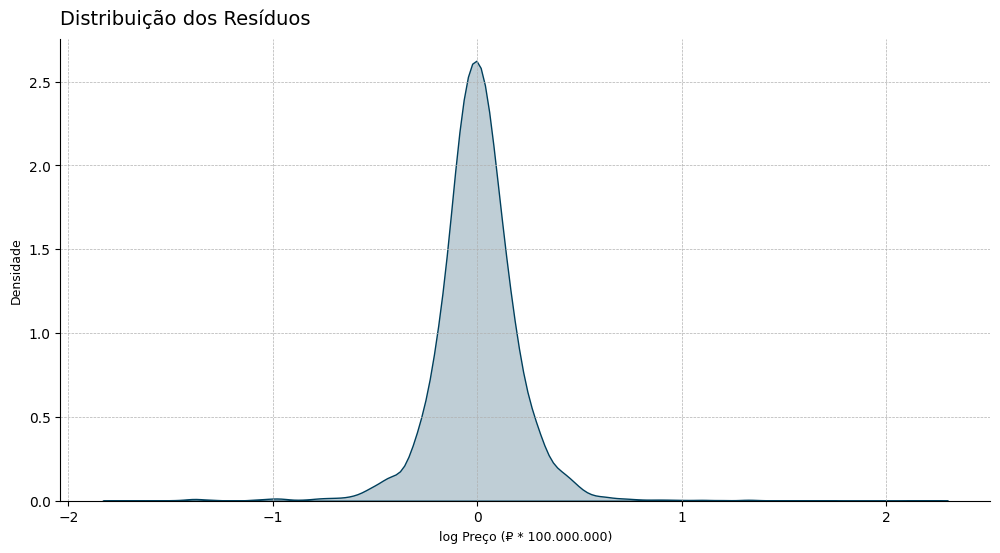

In [41]:
residuos = y_test - y_pred

fig, ax = plt.subplots(figsize = (12, 6))

sns.kdeplot(residuos, fill = True)
ax.set_title("Distribuição dos Resíduos", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("log Preço (₽ * 100.000.000)", fontsize = 9)
ax.set_ylabel("Densidade", fontsize = 9)
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Para fechar vamos visualizar as Feature Importances, por padrão no XGBoost elas são do tipo gain, que indica o quanto cada feature é importante na acurácia de uma previsão. 

In [42]:
regressor = reg.named_steps['regressor']
importances = regressor.feature_importances_

In [43]:
feature_importances_df = pd.DataFrame({
    'feature': X_train.columns.to_list(),
    'importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by = "importance", ascending = False)

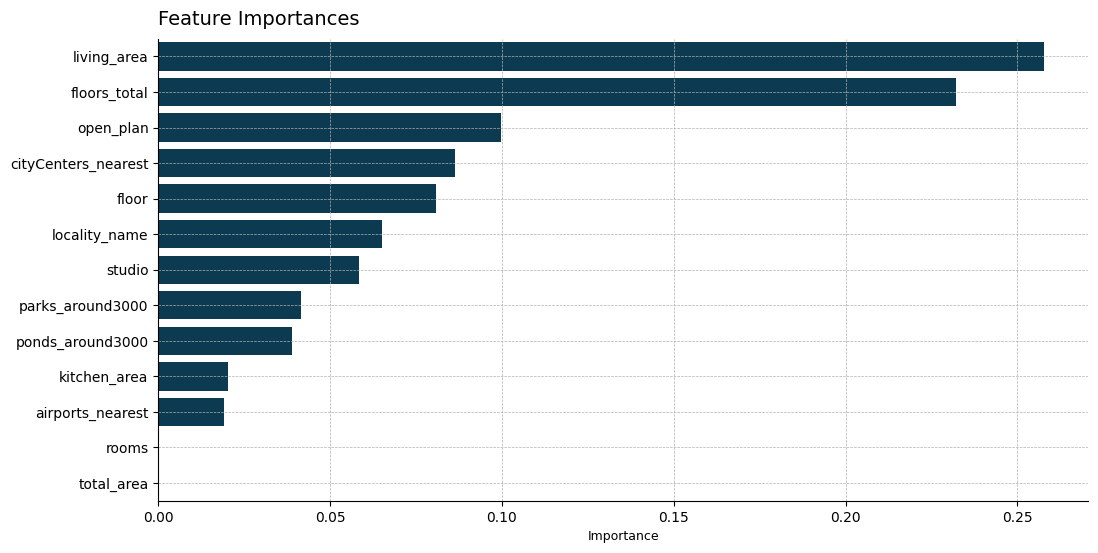

In [44]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(feature_importances_df, x = "importance", y = "feature")
ax.set_title("Feature Importances", fontsize = 14, pad = 10, loc = "left")
ax.set_xlabel("Importance", fontsize = 9)
ax.set_ylabel("")
ax.grid(True, linestyle = '--', linewidth = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()